In [1]:
from pyspark import SparkContext

# Stop the existing SparkContext if it is not None
sc = SparkContext.getOrCreate()
if sc:
    sc.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 12:51:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("SFC").getOrCreate()

sc = spark.sparkContext


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(60)

In [4]:
%%sh
#Let see the first 5 rows
head -5 train.csv

Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921


In [30]:
#Read the data into spark datafrome
# Record the start time
start_time = time.time()

from pyspark.sql.functions import col, lower
df = spark.read.format('csv')\
          .option('header','true')\
          .option('inferSchema', 'true')\
          .option('timestamp', 'true')\
          .load('train.csv')

# Record the end time
end_time = time.time()

# Calculate the time taken
loading_time = end_time - start_time

# Print the loading time
print(f"Time taken for loading data: {loading_time} seconds")

data = df.select(lower(col('Category')),lower(col('Descript')))\
        .withColumnRenamed('lower(Category)','Category')\
        .withColumnRenamed('lower(Descript)', 'Description')
data.cache()
print('Dataframe Structure')
print('----------------------------------')
print(data.printSchema())
print(' ')
print('Dataframe preview')
print(data.show(5))
print(' ')
print('----------------------------------')
print('Total number of rows', df.count())


23/12/13 14:12:39 WARN CacheManager: Asked to cache already cached data.        


Time taken for loading data: 0.8943850994110107 seconds
Dataframe Structure
----------------------------------
root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)

None
 
Dataframe preview
+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      warrants|      warrant arrest|
|other offenses|traffic violation...|
|other offenses|traffic violation...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
+--------------+--------------------+
only showing top 5 rows

None
 
----------------------------------
Total number of rows 878049


In [6]:
def top_n_list(df,var, N):
    '''
    This function determine the top N numbers of the list
    '''
    print("Total number of unique value of"+' '+var+''+':'+' '+str(df.select(var).distinct().count()))
    print(' ')
    print('Top'+' '+str(N)+' '+'Crime'+' '+var)
    df.groupBy(var).count().withColumnRenamed('count','totalValue')\
    .orderBy(col('totalValue').desc()).show(N)
    
    
top_n_list(data, 'Category',10)
print(' ')
print(' ')
top_n_list(data,'Description',10)

Total number of unique value of Category: 39
 
Top 10 Crime Category
+--------------+----------+
|      Category|totalValue|
+--------------+----------+
| larceny/theft|    174900|
|other offenses|    126182|
|  non-criminal|     92304|
|       assault|     76876|
| drug/narcotic|     53971|
| vehicle theft|     53781|
|     vandalism|     44725|
|      warrants|     42214|
|      burglary|     36755|
|suspicious occ|     31414|
+--------------+----------+
only showing top 10 rows

 
 
Total number of unique value of Description: 879
 
Top 10 Crime Description
+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft from ...|     19771|
|malicious mischie...|   

In [7]:
data.select('Category').distinct().count()

39

In [8]:
training, test = data.randomSplit([0.7,0.3], seed=60)
#trainingSet.cache()
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 614457
Test Dataset Count: 263592


In [9]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes 

#----------------Define tokenizer with regextokenizer()------------------
regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

#----------------Define stopwords with stopwordsremover()---------------------
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)
                    

#----------Define bags of words using countVectorizer()---------------------------
count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")


#-----------Using TF-IDF to vectorise features instead of countVectoriser-----------------
hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")
            
#Use minDocFreq to remove sparse terms
idf = IDF(minDocFreq=5)\
        .setInputCol("raw_features")\
        .setOutputCol("features")

#---------------Define bag of words using Word2Vec---------------------------
word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

#-----------Encode the Category variable into label using StringIndexer-----------
label_string_idx = StringIndexer()\
                  .setInputCol("Category")\
                  .setOutputCol("label")

#-----------Define classifier structure for logistic Regression--------------
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

#---------Define classifier structure for Naive Bayes----------
nb = NaiveBayes(smoothing=1)

def metrics_ev(labels, metrics):
    '''
    List of all performance metrics
    '''
    # Confusion matrix
    print("---------Confusion matrix-----------------")
    print(metrics.confusionMatrix)
    print(' ')    
    # Overall statistics
    print('----------Overall statistics-----------')
    print("Precision = %s" %  metrics.precision())
    print("Recall = %s" %  metrics.recall())
    print("F1 Score = %s" % metrics.fMeasure())
    print(' ')
    # Statistics by class
    print('----------Statistics by class----------')
    for label in sorted(labels):
       print("Class %s precision = %s" % (label, metrics.precision(label)))
       print("Class %s recall = %s" % (label, metrics.recall(label)))
       print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print(' ')
    # Weighted stats
    print('----------Weighted stats----------------')
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    

In [10]:

pipeline_cv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)

23/12/13 12:51:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/13 12:51:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/12/13 12:51:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [11]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_cv_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184383112,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184383112,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184383112,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184383112,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184383112,0.02156...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
evaluator_cv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lr)
print(' ')
print('------------------------------Accuracy----------------------------------')
print(' ')
print('                       accuracy:{}:'.format(evaluator_cv_lr))

 
------------------------------Accuracy----------------------------------
 
                       accuracy:0.9723579882349168:


In [17]:
import pyspark
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lower

# Create a Spark session
spark = pyspark.sql.SparkSession.builder.appName("SFC").getOrCreate()
sc = spark.sparkContext

# Read the data into a Spark DataFrame
df = spark.read.format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .option('timestamp', 'true')\
    .load('train.csv')

# Preprocess the data
data = df.select(lower(col('Category')), lower(col('Descript')))\
    .withColumnRenamed('lower(Category)', 'Category')\
    .withColumnRenamed('lower(Descript)', 'Description')
data.cache()

# Function to determine the top N values in a column
def top_n_list(df, var, N):
    print("Total number of unique values of {} : {}".format(var, df.select(var).distinct().count()))
    print('\nTop {} Crime {}:'.format(N, var))
    df.groupBy(var).count().withColumnRenamed('count', 'totalValue')\
        .orderBy(col('totalValue').desc()).show(N)

# Display top categories and descriptions
top_n_list(data, 'Category', 10)
top_n_list(data, 'Description', 10)

# Split the data into training and test sets
training, test = data.randomSplit([0.7, 0.3], seed=60)

# Define the stages for the pipeline
regex_tokenizer = RegexTokenizer(pattern='\\W')\
    .setInputCol("Description")\
    .setOutputCol("tokens")

extra_stopwords = ['http', 'amp', 'rt', 't', 'c', 'the']
stopwords_remover = StopWordsRemover()\
    .setInputCol('tokens')\
    .setOutputCol('filtered_words')\
    .setStopWords(extra_stopwords)

count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
    .setInputCol("filtered_words")\
    .setOutputCol("features")

# Use handleInvalid="keep" to handle unseen labels
label_string_idx = StringIndexer()\
    .setInputCol("Category")\
    .setOutputCol("label")\
    .setHandleInvalid("keep")

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Define the pipeline
pipeline = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])

# Define the parameter grid for cross-validation
param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.3, 0.5])\
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4])\
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Define the CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model using cross-validation
cv_model = crossval.fit(training)

# Make predictions on the test set
predictions_cv = cv_model.transform(test)

# Evaluate the model
accuracy = evaluator.evaluate(predictions_cv)
print("Accuracy: {}".format(accuracy))

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Display the best parameters
print("Best RegParam: {}".format(best_model.stages[-1]._java_obj.getRegParam()))
print("Best ElasticNetParam: {}".format(best_model.stages[-1]._java_obj.getElasticNetParam()))


23/12/13 13:07:11 WARN CacheManager: Asked to cache already cached data.        


Total number of unique values of Category : 39

Top 10 Crime Category:
+--------------+----------+
|      Category|totalValue|
+--------------+----------+
| larceny/theft|    174900|
|other offenses|    126182|
|  non-criminal|     92304|
|       assault|     76876|
| drug/narcotic|     53971|
| vehicle theft|     53781|
|     vandalism|     44725|
|      warrants|     42214|
|      burglary|     36755|
|suspicious occ|     31414|
+--------------+----------+
only showing top 10 rows

Total number of unique values of Description : 879

Top 10 Crime Description:
+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft from ...|     19771|
|malicious mischie...|   

23/12/13 13:08:54 WARN CacheManager: Asked to cache already cached data.        
23/12/13 13:08:54 WARN CacheManager: Asked to cache already cached data.
23/12/13 13:10:40 WARN BlockManager: Asked to remove block broadcast_9564, which does not exist


Accuracy: 0.993804819569638
Best RegParam: 0.1
Best ElasticNetParam: 0.0


In [19]:
import pyspark
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lower
import time

# Start the timer for loading data
start_time_loading_data = time.time()

# Create a Spark session
spark = pyspark.sql.SparkSession.builder.appName("SFC").getOrCreate()
sc = spark.sparkContext

# Read the data into a Spark DataFrame
df = spark.read.format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .option('timestamp', 'true')\
    .load('train.csv')

# End the timer for loading data
end_time_loading_data = time.time()

# Calculate and print the loading data time
loading_data_time = end_time_loading_data - start_time_loading_data
print(f"Loading Data Time: {loading_data_time} seconds")

# Preprocess the data
data = df.select(lower(col('Category')), lower(col('Descript')))\
    .withColumnRenamed('lower(Category)', 'Category')\
    .withColumnRenamed('lower(Descript)', 'Description')
data.cache()

# Function to determine the top N values in a column
def top_n_list(df, var, N):
    print("Total number of unique values of {} : {}".format(var, df.select(var).distinct().count()))
    print('\nTop {} Crime {}:'.format(N, var))
    df.groupBy(var).count().withColumnRenamed('count', 'totalValue')\
        .orderBy(col('totalValue').desc()).show(N)

# Display top categories and descriptions
top_n_list(data, 'Category', 10)
top_n_list(data, 'Description', 10)

# Split the data into training and test sets
training, test = data.randomSplit([0.7, 0.3], seed=60)

# Define the stages for the pipeline
regex_tokenizer = RegexTokenizer(pattern='\\W')\
    .setInputCol("Description")\
    .setOutputCol("tokens")

extra_stopwords = ['http', 'amp', 'rt', 't', 'c', 'the']
stopwords_remover = StopWordsRemover()\
    .setInputCol('tokens')\
    .setOutputCol('filtered_words')\
    .setStopWords(extra_stopwords)

count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
    .setInputCol("filtered_words")\
    .setOutputCol("features")

# Use handleInvalid="keep" to handle unseen labels
label_string_idx = StringIndexer()\
    .setInputCol("Category")\
    .setOutputCol("label")\
    .setHandleInvalid("keep")

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Define the pipeline
pipeline = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])

# Define the parameter grid for cross-validation
param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.3, 0.5])\
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4])\
    .build()

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Define the CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Start the timer for GridSearchCV
start_time_gridsearch = time.time()

# Fit the model using cross-validation
cv_model = crossval.fit(training)

# End the timer for GridSearchCV
end_time_gridsearch = time.time()

# Calculate and print execution time for GridSearchCV
gridsearch_time = end_time_gridsearch - start_time_gridsearch
print(f"GridSearchCV Execution Time: {gridsearch_time} seconds")

# Make predictions on the test set
predictions_cv = cv_model.transform(test)

# Evaluate the model
accuracy = evaluator.evaluate(predictions_cv)
print("Accuracy: {}".format(accuracy))

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Display the best parameters
print("Best RegParam: {}".format(best_model.stages[-1]._java_obj.getRegParam()))
print("Best ElasticNetParam: {}".format(best_model.stages[-1]._java_obj.getElasticNetParam()))


23/12/13 13:25:15 WARN CacheManager: Asked to cache already cached data.        


Loading Data Time: 1.0222420692443848 seconds
Total number of unique values of Category : 39

Top 10 Crime Category:
+--------------+----------+
|      Category|totalValue|
+--------------+----------+
| larceny/theft|    174900|
|other offenses|    126182|
|  non-criminal|     92304|
|       assault|     76876|
| drug/narcotic|     53971|
| vehicle theft|     53781|
|     vandalism|     44725|
|      warrants|     42214|
|      burglary|     36755|
|suspicious occ|     31414|
+--------------+----------+
only showing top 10 rows

Total number of unique values of Description : 879

Top 10 Crime Description:
+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft 

GridSearchCV Execution Time: 276.05048298835754 seconds
Accuracy: 0.993804819569638
Best RegParam: 0.1
Best ElasticNetParam: 0.0


In [20]:
lr_pipeline = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(count_vectors.vocabSize, [5000]) \
    .addGrid(count_vectors.minDF, [5]) \
    .addGrid(lr.maxIter, [100]) \
    .addGrid(lr.regParam, [0.5]) \
    .build()

# Create a CrossValidator with Logistic Regression as the estimator
crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  # You can adjust the number of folds

# Record start time
start_time = time.time()

# Fit the CrossValidator to the training data and find the best parameters
cv_model = crossval.fit(training)  # Use your training DataFrame instead of df

# Record end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the best parameters
print("Best Parameters: {}".format(cv_model.bestModel.stages[0].extractParamMap()))
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

# Use the best model to make predictions on the test data
predictions = cv_model.transform(test)


Best Parameters: {Param(parent='RegexTokenizer_f03f217cb58a', name='gaps', doc='whether regex splits on gaps (True) or matches tokens (False)'): True, Param(parent='RegexTokenizer_f03f217cb58a', name='minTokenLength', doc='minimum token length (>= 0)'): 1, Param(parent='RegexTokenizer_f03f217cb58a', name='outputCol', doc='output column name.'): 'tokens', Param(parent='RegexTokenizer_f03f217cb58a', name='pattern', doc='regex pattern (Java dialect) used for tokenizing'): '\\W', Param(parent='RegexTokenizer_f03f217cb58a', name='toLowercase', doc='whether to convert all characters to lowercase before tokenizing'): True, Param(parent='RegexTokenizer_f03f217cb58a', name='inputCol', doc='input column name.'): 'Description'}
Elapsed Time: 105.80 seconds


Total Execution Time: 628.42 seconds


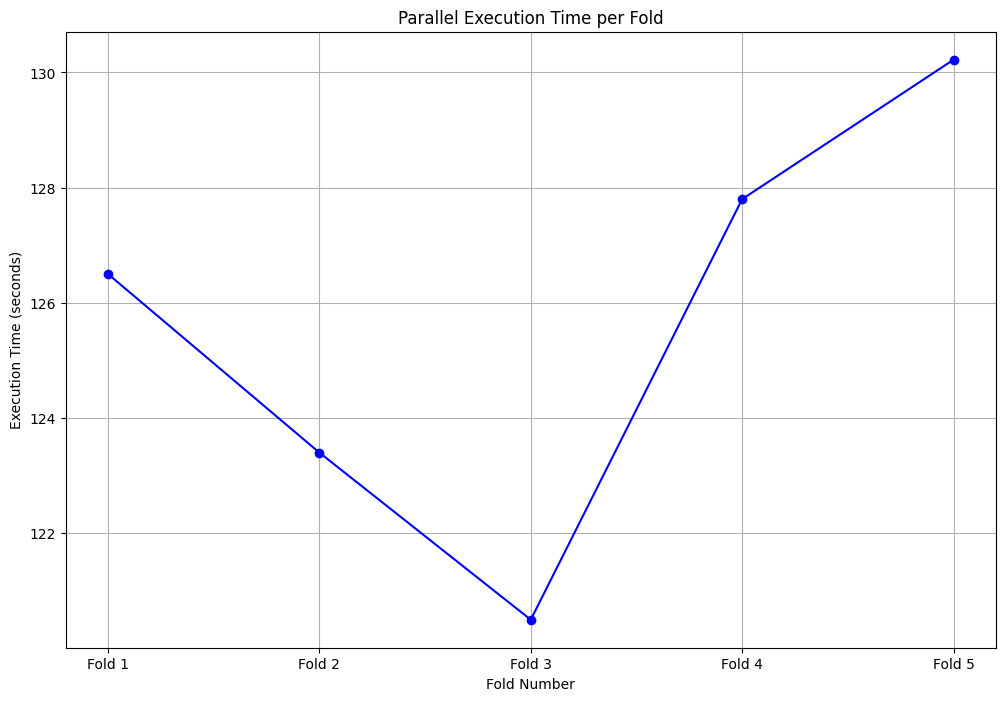

In [32]:
# Calculate total execution time
total_execution_time = np.sum(execution_times_per_fold)

# Print the total execution time
print(f"Total Execution Time: {total_execution_time} seconds")

# Labels for the plot
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Plot the execution times per fold
plt.figure(figsize=(12, 8))
plt.plot(labels, execution_times_per_fold, marker='o', linestyle='-', color='b')
plt.title("Parallel Execution Time per Fold")
plt.xlabel("Fold Number")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)
plt.show()

In [37]:
lr_pipeline = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])

# Define the parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(count_vectors.vocabSize, [5000]) \
    .addGrid(count_vectors.minDF, [5]) \
    .addGrid(word2Vec.vectorSize, [100, 150]) \
    .addGrid(word2Vec.minCount, [0, 5, 10]) \
    .addGrid(lr.maxIter, [100]) \
    .addGrid(lr.regParam, [0.5]) \
    .build()

# Create a CrossValidator with Logistic Regression as the estimator
crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)

# Record start time
start_time = time.time()

# Fit the CrossValidator to the training data and find the best parameters
cv_model = crossval.fit(training) 

# Record end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the best parameters
print("Best Parameters: {}".format(cv_model.bestModel.stages[0].extractParamMap()))
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

# Use the best model to make predictions on the test data
predictions = cv_model.transform(test)

Best Parameters: {Param(parent='RegexTokenizer_d0a4ec9e97e3', name='gaps', doc='whether regex splits on gaps (True) or matches tokens (False)'): True, Param(parent='RegexTokenizer_d0a4ec9e97e3', name='minTokenLength', doc='minimum token length (>= 0)'): 1, Param(parent='RegexTokenizer_d0a4ec9e97e3', name='outputCol', doc='output column name.'): 'tokens', Param(parent='RegexTokenizer_d0a4ec9e97e3', name='pattern', doc='regex pattern (Java dialect) used for tokenizing'): '\\W', Param(parent='RegexTokenizer_d0a4ec9e97e3', name='toLowercase', doc='whether to convert all characters to lowercase before tokenizing'): True, Param(parent='RegexTokenizer_d0a4ec9e97e3', name='inputCol', doc='input column name.'): 'Description'}
Elapsed Time: 516.04 seconds
